### chapter 2

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

- 뒷쪽의 2-4 예제 먼저..
- columns
    - price: 자동차 가격
    - maint: 자동차 유지 비용
    - dours: 자동차 문의 개수
    - persons: 수용 인원
    - lug_capacity: 수하물 용량
    - sefety: 안정성
    - output: 차상태

In [2]:
car_df = pd.read_csv('./chap02/car_evaluation.csv')
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         1728 non-null   object
 1   maint         1728 non-null   object
 2   doors         1728 non-null   object
 3   persons       1728 non-null   object
 4   lug_capacity  1728 non-null   object
 5   safety        1728 non-null   object
 6   output        1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [3]:
car_df.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
car_df['doors'].value_counts()

doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64

In [5]:
car_df['persons'].value_counts()

persons
2       576
4       576
more    576
Name: count, dtype: int64

In [6]:
car_df.duplicated().sum()

0

In [7]:
colname = car_df.columns.to_list()
type(colname), colname

(list,
 ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety', 'output'])

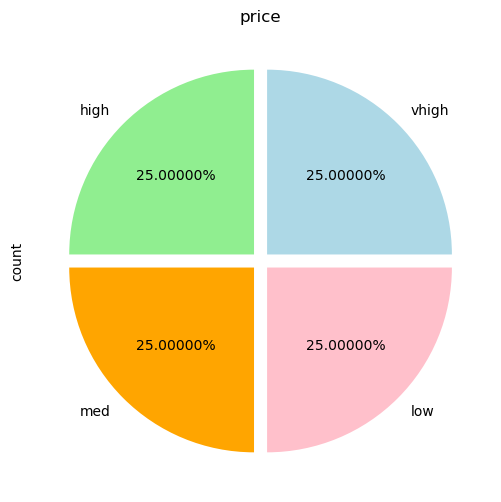

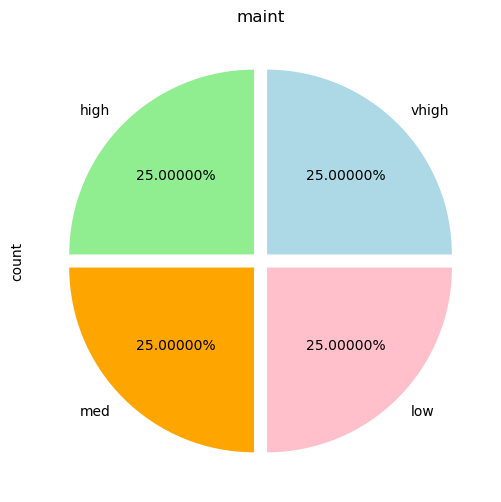

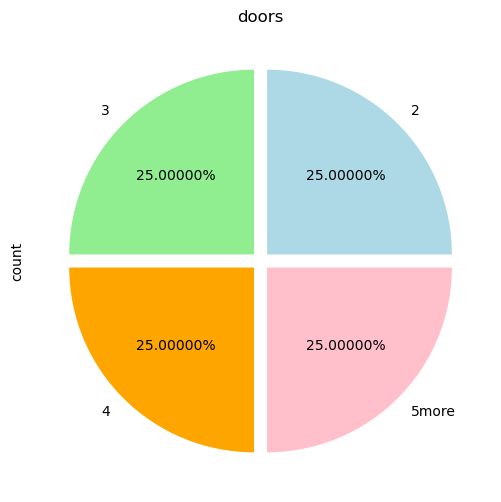

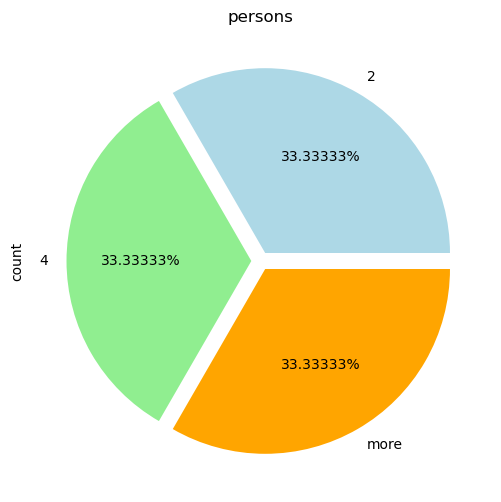

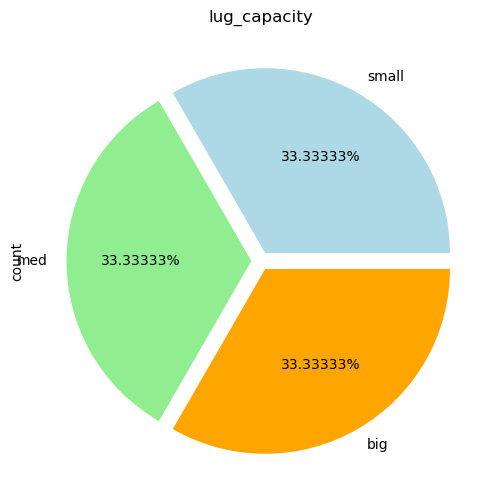

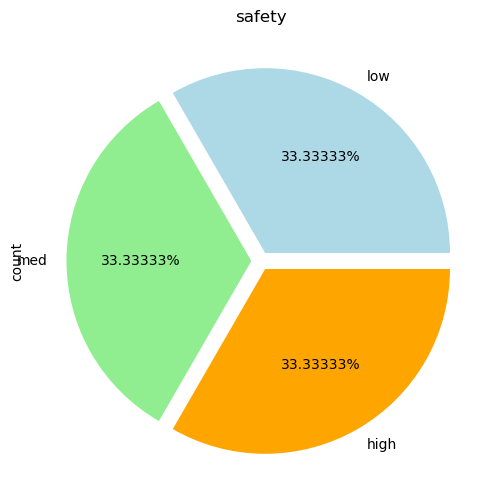

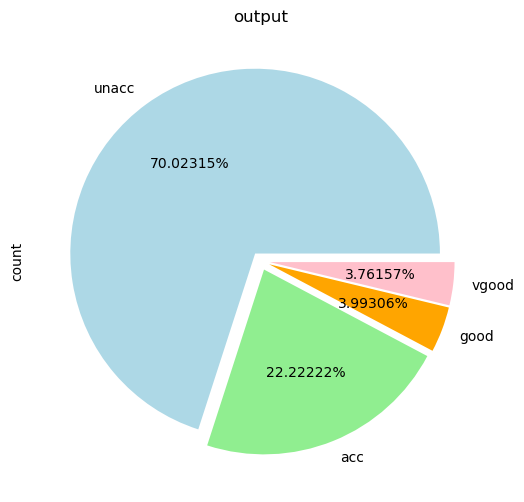

In [8]:
# data distribution
# value_counts()를 이용
colname = car_df.columns.to_list()
for col in colname:
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 8; fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size

    try:
        car_df[col].value_counts().plot(kind='pie', autopct='%0.05f%%',
                                        colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05, 0.05))
    except:
        car_df[col].value_counts().plot(kind='pie', autopct='%0.05f%%',
                                        colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05))
    plt.title(col)
    plt.show()

In [9]:
del colname[-1]

In [10]:
# data encoding

for col in colname:
    car_df[col] = car_df[col].astype('category')
    
price = car_df['price'].cat.codes.values
maint = car_df['maint'].cat.codes.values
doors = car_df['doors'].cat.codes.values
person = car_df['persons'].cat.codes.values
lug_capacity = car_df['lug_capacity'].cat.codes.values
safety = car_df['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, person, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

- categorical data -> DataFrame[category] -> numpy array -> tensor

In [11]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [12]:
# label
outputs = pd.get_dummies(car_df['output'])
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()   # 1D

print(categorical_data.shape, outputs.shape)

torch.Size([1728, 6]) torch.Size([6912])


In [13]:
categorical_column_sizes = [len(car_df[column].cat.categories) for column in colname]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1) // 2)) for col_size in categorical_column_sizes]
categorical_embedding_sizes

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]

- validation loss 보고 싶으면 여기서 validaton data를 나눠야함.. 하...

In [14]:
total_records = 1728
test_records = int(total_records * .2) # 전체의 20% 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]

train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [15]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [16]:
# create model network

class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()  # 문법인가?
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols       # 입력층의 크기를 찾기 위해 범주형 칼럼 개수를 input_size에 저장
        
        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i
            
        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)
        # 신경망의 모든 계층이 순차적으로 실행되도록 모든 계층에 대한 목록(all_layers)을 nn.Sequential 클래스로 전달
        
    # 순전파인가?
    def forward(self, x_categorical):
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
            
        x = torch.cat(embeddings, 1)    # 넘파이의 concatenate와 같지만 대상이 텐서가 됨
        x = self.embedding_dropout(x)
        x = self.layers(x)

        return x

In [58]:
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [59]:
# model parameter
loss_function = nn.CrossEntropyLoss()   # 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)      # 옵티마이저: 최적화 하려고 사용하는 거. 활성함수 비슷?, lr: 학습률

In [60]:
if torch.cuda.is_available():
    device = torch.device('gpu')
else:
    device = torch.device('cpu')

In [61]:
# model learning

epochs = 30000       # 학습 횟수?
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)   # 반복할 때마다 오차를 저장
    
    if i%25 == 1:
        print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")
        
    optimizer.zero_grad()
    single_loss.backward()
    # 가중치를 업데이트하기 위해 손실함수의 backward() 메서드를 호출, 오차역전파!!!
    optimizer.step()    # 옵티마이저의 step() 메서드를 이용하여 기울기 업데이트

# print(f"epoch: {i:3} loss: {single_loss.item():10.10f}")     # 오차가 25 epoch 마다 출력

epoch:   1 loss: 1.49917841
epoch:  26 loss: 1.31273520
epoch:  51 loss: 1.24089789
epoch:  76 loss: 1.14650464
epoch: 101 loss: 1.02755725
epoch: 126 loss: 0.88991165
epoch: 151 loss: 0.81904954
epoch: 176 loss: 0.74334300
epoch: 201 loss: 0.68600863
epoch: 226 loss: 0.65344536
epoch: 251 loss: 0.62147981
epoch: 276 loss: 0.61842221
epoch: 301 loss: 0.60572350
epoch: 326 loss: 0.60493505
epoch: 351 loss: 0.58443469
epoch: 376 loss: 0.59220028
epoch: 401 loss: 0.57607895
epoch: 426 loss: 0.56976223
epoch: 451 loss: 0.57873189
epoch: 476 loss: 0.57449782
epoch: 501 loss: 0.57532352
epoch: 526 loss: 0.56958753
epoch: 551 loss: 0.57355374
epoch: 576 loss: 0.57267934
epoch: 601 loss: 0.56251717
epoch: 626 loss: 0.56598967
epoch: 651 loss: 0.56496686
epoch: 676 loss: 0.56275898
epoch: 701 loss: 0.56440938
epoch: 726 loss: 0.56699967
epoch: 751 loss: 0.56083173
epoch: 776 loss: 0.55950171
epoch: 801 loss: 0.55538845
epoch: 826 loss: 0.55701846
epoch: 851 loss: 0.56033057
epoch: 876 loss: 0.5

In [62]:
# test
test_outputs = test_outputs.to(device=device, dtype=torch.int64)

with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f"Loss: {loss:.8f}")

Loss: 0.46753660


In [63]:
print(y_val[:5])

tensor([[  9.5845,   2.1631, -19.8030, -19.7551],
        [  0.5960,   0.0601, -17.1277, -16.7324],
        [  1.4922,   0.4462, -14.7448, -14.3652],
        [ -0.8026,   0.1116, -17.0318, -16.6753],
        [  0.1835,  -0.5312, -14.0753, -13.5443]])


In [64]:
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])    # 가장 큰 값을 가지는 인덱스 추출

tensor([0, 0, 0, 1, 0])


In [65]:
# 정홛도 확인
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [66]:
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val, zero_division=0))
print(f'accuracy score: {accuracy_score(test_outputs, y_val)*100:.2f} %')

[[252   7]
 [ 62  24]]
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       259
           1       0.77      0.28      0.41        86

    accuracy                           0.80       345
   macro avg       0.79      0.63      0.64       345
weighted avg       0.80      0.80      0.76       345

accuracy score: 80.00 %


In [105]:
# loss_function(model(categorical_test_data), test_outputs)

test_losses = []

for i in range(len(test_outputs)):
    y_pred = model(categorical_test_data).to(device)
    test_loss = loss_function(y_pred, test_outputs)
    test_losses.append(test_loss)   # 반복할 때마다 오차를 저장
    
print(test_losses)

[tensor(0.4573, grad_fn=<NllLossBackward0>), tensor(0.4503, grad_fn=<NllLossBackward0>), tensor(0.5007, grad_fn=<NllLossBackward0>), tensor(0.4604, grad_fn=<NllLossBackward0>), tensor(0.5176, grad_fn=<NllLossBackward0>), tensor(0.4494, grad_fn=<NllLossBackward0>), tensor(0.4464, grad_fn=<NllLossBackward0>), tensor(0.4465, grad_fn=<NllLossBackward0>), tensor(0.4081, grad_fn=<NllLossBackward0>), tensor(0.4655, grad_fn=<NllLossBackward0>), tensor(0.4432, grad_fn=<NllLossBackward0>), tensor(0.4895, grad_fn=<NllLossBackward0>), tensor(0.5825, grad_fn=<NllLossBackward0>), tensor(0.4256, grad_fn=<NllLossBackward0>), tensor(0.4768, grad_fn=<NllLossBackward0>), tensor(0.4330, grad_fn=<NllLossBackward0>), tensor(0.4662, grad_fn=<NllLossBackward0>), tensor(0.4699, grad_fn=<NllLossBackward0>), tensor(0.4844, grad_fn=<NllLossBackward0>), tensor(0.4877, grad_fn=<NllLossBackward0>), tensor(0.4654, grad_fn=<NllLossBackward0>), tensor(0.4681, grad_fn=<NllLossBackward0>), tensor(0.4306, grad_fn=<NllLoss

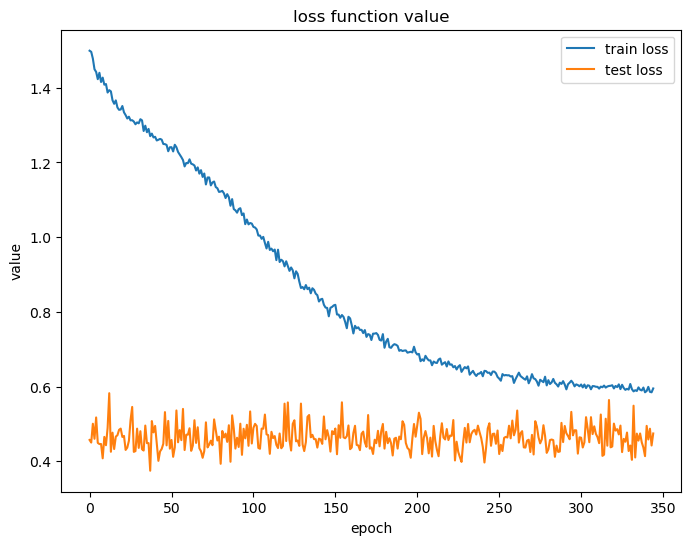

In [107]:
# aggregated_losses[0].item()
train_loss_list = []
for i in aggregated_losses:
    train_loss_list.append(i.item())
test_loss_list = []
for i in test_losses:
    test_loss_list.append(i.item())
    
plt.plot(train_loss_list[:len(test_outputs)], label='train loss')
plt.plot(test_loss_list, label='test loss')

plt.title('loss function value')
# plt.xticks(np.arange(1, 30000, 3000))
plt.ylabel('value')
plt.legend()
plt.show()

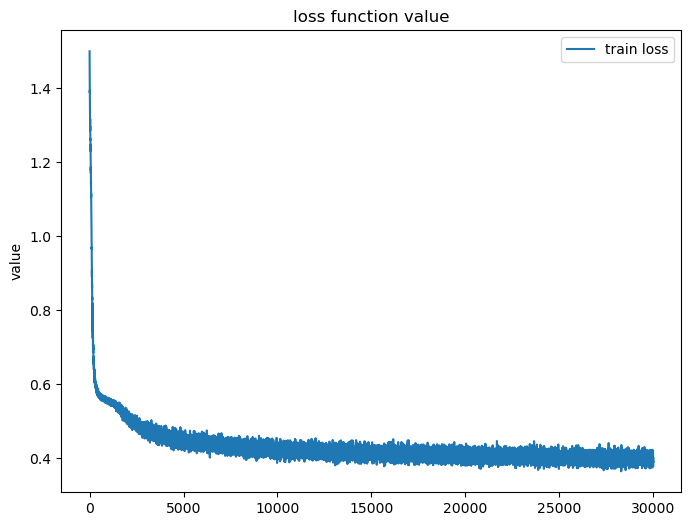

In [108]:
# aggregated_losses[0].item()
train_loss_list = []
for i in aggregated_losses:
    train_loss_list.append(i.item())
# test_loss_list = []
# for i in test_losses:
#     test_loss_list.append(i.item())
    
plt.plot(train_loss_list, label='train loss')
# plt.plot(test_loss_list, label='test loss')

plt.title('loss function value')
# plt.xticks(np.arange(1, 30000, 3000))
plt.ylabel('value')
plt.legend()
plt.show()